In [1]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path.cwd().parent
PLOTS_DIR = PROJECT_ROOT/"plots"
DATA_DIR = PROJECT_ROOT/"data"
sys.path.append(str(PROJECT_ROOT))

from src.regime import (
    prepare_hmm_features,
    train_hmm,
    predict_regimes,
    map_regimes_to_trend
)

df = pd.read_csv(
    PROJECT_ROOT / "data" / "features" / "nifty_features_5min.csv",
    parse_dates=["timestamp"]
).sort_values("timestamp").reset_index(drop=True)

print(df.shape)

(19212, 2666)


In [2]:
# HMM inpyt features

hmm_features = [
    "avg_iv",
    "iv_spread",
    "pcr_oi",
    "ce_delta",
    "ce_gamma",
    "ce_vega",
    "futures_basis",
    "spot_returns"
]


#### train and test split

In [3]:
split_idx = int(len(df) * 0.7)
train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

#### Preparing features and train hmm

In [5]:
idx_train, X_train, scaler = prepare_hmm_features(
    train_df, hmm_features
)

hmm_model = train_hmm(X_train, n_states=3)


Model is not converging.  Current: 157573.4434617696 is not greater than 284314.8399148879. Delta is -126741.3964531183


#### Predicting regimes

In [6]:
# Train
train_df.loc[idx_train, "raw_regime"] = predict_regimes(
    hmm_model, X_train
)

# Test
idx_test, X_test, _ = prepare_hmm_features(
    test_df, hmm_features
)

test_df.loc[idx_test, "raw_regime"] = predict_regimes(
    hmm_model, X_test
)

df = pd.concat([train_df, test_df]).sort_index()


In [7]:
# map regimes to +1/0/-1

df, regime_mapping = map_regimes_to_trend(df, "raw_regime")

print("Regime mapping:", regime_mapping)


Regime mapping: {np.float64(nan): 0, np.float64(0.0): 1, np.float64(2.0): 1, np.float64(1.0): 1}


In [8]:
df["regime"].value_counts(dropna=False)


regime
1    17338
0     1874
Name: count, dtype: int64

In [9]:
df.to_csv(DATA_DIR / "nifty_with_regimes.csv", index=False)

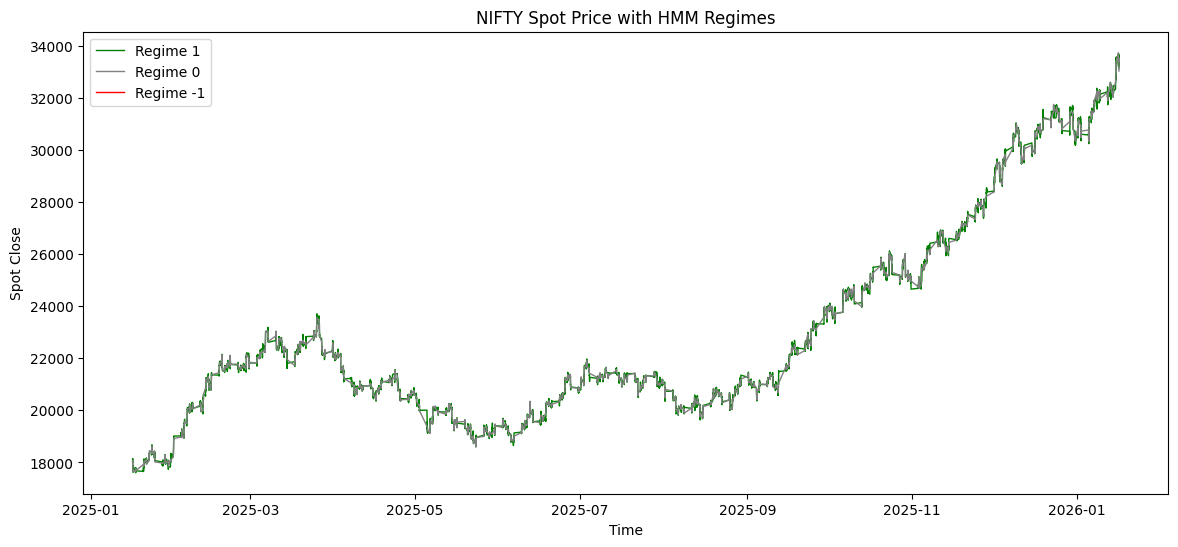

In [8]:
# overplay plot

plt.figure(figsize=(14,6))

colors = {1: "green", 0: "gray", -1: "red"}

for r, color in colors.items():
    mask = df["regime"] == r
    plt.plot(
        df.loc[mask, "timestamp"],
        df.loc[mask, "spot_close"],
        color=color,
        label=f"Regime {r}",
        linewidth=1
    )

plt.legend()
plt.title("NIFTY Spot Price with HMM Regimes")
plt.xlabel("Time")
plt.ylabel("Spot Close")
plt.show()

plt.savefig(PLOTS_DIR/"regime_overplay.png", dpi=150, bbox_inches="tight")
plt.close()

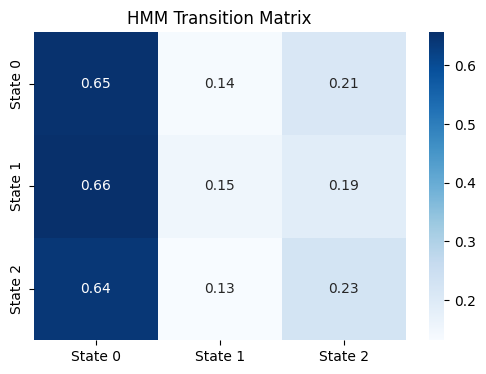

In [9]:
# transition matric
trans_mat = pd.DataFrame(
    hmm_model.transmat_,
    columns=[f"State {i}" for i in range(hmm_model.n_components)],
    index=[f"State {i}" for i in range(hmm_model.n_components)]
)

plt.figure(figsize=(6,4))
sns.heatmap(trans_mat, annot=True, cmap="Blues", fmt=".2f")
plt.title("HMM Transition Matrix")
plt.show()

plt.savefig(PLOTS_DIR/"hmm_transition_matrix.png", dpi=150, bbox_inches="tight")
plt.close()

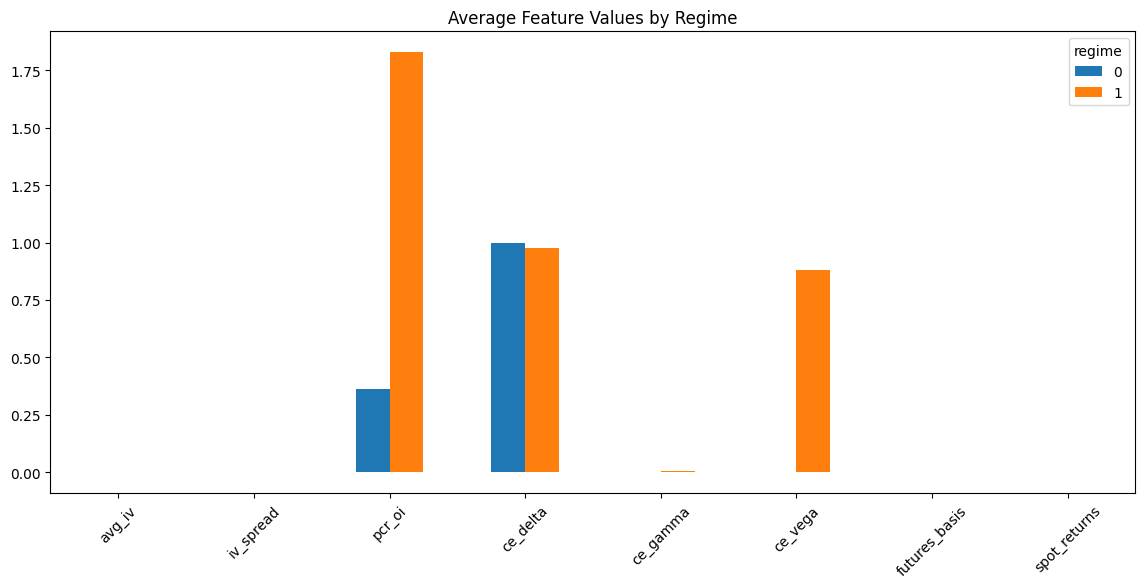

In [12]:
regime_stats = (
    df.groupby("regime")[hmm_features]
    .mean()
)

regime_stats

regime_stats.T.plot(kind="bar", figsize=(14,6))
plt.title("Average Feature Values by Regime")
plt.xticks(rotation=45)
plt.show()

plt.savefig(PLOTS_DIR/"avg_features_by_regime.png", dpi=150, bbox_inches="tight")
plt.close()

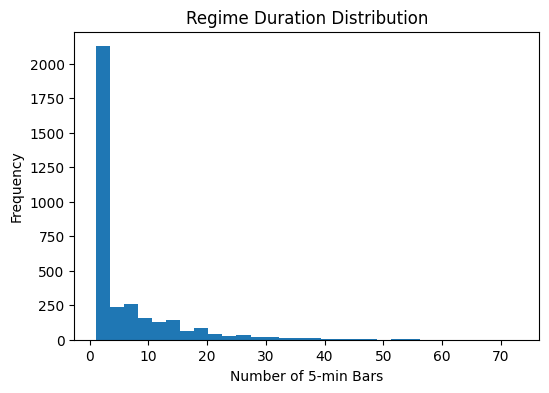

In [15]:
df["regime_block"] = (df["regime"] != df["regime"].shift()).cumsum()

durations = (
    df.groupby("regime_block")
    .size()
)

plt.figure(figsize=(6,4))
plt.hist(durations, bins=30)
plt.title("Regime Duration Distribution")
plt.xlabel("Number of 5-min Bars")
plt.ylabel("Frequency")
plt.show()

plt.savefig(PLOTS_DIR/"regime_duration_hist.png", dpi=150, bbox_inches="tight")
plt.close()